**Collab conecting**

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
folder = '/content/drive/MyDrive/SISS_2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import nibabel as nib

**Visualize**

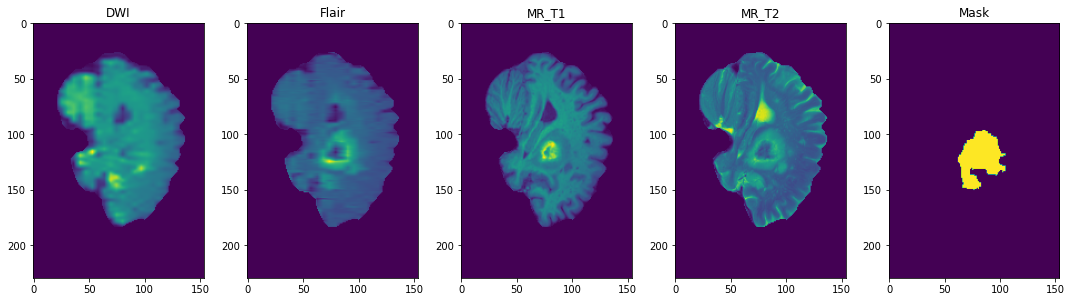

In [ ]:
def visualise_slice(idx, slice_, ax_ = 0):
  im_1 = nib.load(folder + f'/DWI/{idx+1}_DWI.nii').get_fdata()
  im_2 = nib.load(folder + f'/Flair/{idx+1}_Flair.nii').get_fdata()
  im_3 = nib.load(folder + f'/MR_T1/{idx+1}_MR_T1.nii').get_fdata()
  im_4 = nib.load(folder + f'/MR_T2/{idx+1}_MR_T2.nii').get_fdata()
  im_5 = nib.load(folder + f'/Mask/{idx+1}_Mask.nii').get_fdata()

  if ax_ == 0:
    im_1 = im_1[slice_, :, :]
    im_2 = im_2[slice_, :, :]
    im_3 = im_3[slice_, :, :]
    im_4 = im_4[slice_, :, :]
    im_5 = im_5[slice_, :, :]
  elif ax_ == 1:
    im_1 = im_1[:, slice_, :]
    im_2 = im_2[:, slice_, :]
    im_3 = im_3[:, slice_, :]
    im_4 = im_4[:, slice_, :]
    im_5 = im_5[:, slice_, :]
  else:
    im_1 = im_1[:, :, slice_]
    im_2 = im_2[:, :, slice_]
    im_3 = im_3[:, :, slice_]
    im_4 = im_4[:, :, slice_]
    im_5 = im_5[:, :, slice_]
  
  width=5
  height=5
  rows = 1
  cols = 5
  axes=[]
  fig=plt.figure(figsize=(15, 8))
  imgs = [im_1, im_2, im_3, im_4, im_5]
  titles = ['DWI', 'Flair', 'MR_T1', 'MR_T2', 'Mask']
  for i in range(5):
      axes.append( fig.add_subplot(1, 5, i+1) )
      axes[-1].set_title(titles[i])  
      plt.imshow(imgs[i])
  fig.tight_layout()
  plt.show()

visualise_slice(1, 84)

**Dataset**

In [ ]:
import scipy.stats as ss

Он получился слегка замысловатым...

In [ ]:
class isles_dataset(Dataset):
  def __init__(self, folder, indexes, augmentation=None, preprocessing=None, mode='train'):
      self.folder = folder
      self.img_indexes = indexes # list
      self.img_counter = 0
      self.mode = mode

      self.DWI = torch.tensor(nib.load(self.folder + f'/DWI/{self.img_indexes[0] + 1}_DWI.nii').get_fdata())[40:190, :, :].double()
      self.Flair = torch.tensor(nib.load(self.folder + f'/Flair/{self.img_indexes[0] + 1}_Flair.nii').get_fdata())[40:190, :, :].double()
      self.MR_T1 = torch.tensor(nib.load(self.folder + f'/MR_T1/{self.img_indexes[0] + 1}_MR_T1.nii').get_fdata())[40:190, :, :].double()
      self.MR_T2 = torch.tensor(nib.load(self.folder + f'/MR_T2/{self.img_indexes[0] + 1}_MR_T2.nii').get_fdata())[40:190, :, :].double()
      self.Mask = torch.tensor(nib.load(self.folder + f'/Mask/{self.img_indexes[0] + 1}_Mask.nii').get_fdata())[40:190, :, :].double()

      self.slice_counter = 0
      self.slice_indexes = np.arange(0, 150, 1)
      np.random.shuffle(self.slice_indexes)
      if self.mode == 'val':
        self.slice_indexes = np.sort(self.slice_indexes)


      self.augmentation = augmentation
      self.preprocessing = preprocessing
      

  def __len__(self):
      return len(self.img_indexes) * (50)

  def restart_slicer(self):
    self.slice_counter = 0
    np.random.shuffle(self.slice_indexes)

    if self.mode == 'val':
      self.slice_indexes = np.sort(self.slice_indexes)

  def restart_images(self):
    self.img_counter = 0
    np.random.shuffle(self.img_indexes)

    if self.mode == 'val':
      self.img_indexes = np.sort(self.img_indexes)

  def next_image(self):
    self.img_counter += 1
    if self.img_counter == len(self.img_indexes):
      self.restart_images()
    del self.DWI
    self.DWI = torch.tensor(nib.load(self.folder + f'/DWI/{self.img_indexes[self.img_counter] + 1}_DWI.nii').get_fdata())[40:190, :, :]
    del self.Flair
    self.Flair = torch.tensor(nib.load(self.folder + f'/Flair/{self.img_indexes[self.img_counter] + 1}_Flair.nii').get_fdata())[40:190, :, :]
    del self.MR_T1
    self.MR_T1 = torch.tensor(nib.load(self.folder + f'/MR_T1/{self.img_indexes[self.img_counter] + 1}_MR_T1.nii').get_fdata())[40:190, :, :]
    del self.MR_T2
    self.MR_T2 = torch.tensor(nib.load(self.folder + f'/MR_T2/{self.img_indexes[self.img_counter] + 1}_MR_T2.nii').get_fdata())[40:190, :, :]
    del self.Mask
    self.Mask = torch.tensor(nib.load(self.folder + f'/Mask/{self.img_indexes[self.img_counter] + 1}_Mask.nii').get_fdata())[40:190, :, :]

    self.restart_slicer()
  
  def __getitem__(self, absolutely_useless_thing):
    DWI = self.DWI[self.slice_indexes[self.slice_counter], :, :].unsqueeze(0)
    Flair = self.Flair[self.slice_indexes[self.slice_counter], :, :].unsqueeze(0)
    MR_T1 = self.MR_T1[self.slice_indexes[self.slice_counter], :, :].unsqueeze(0)
    MR_T2 = self.MR_T2[self.slice_indexes[self.slice_counter], :, :].unsqueeze(0)
    mask = self.Mask[self.slice_indexes[self.slice_counter], :, :].unsqueeze(0)

    self.slice_counter += 1
    if self.slice_counter == 150:
      self.next_image()

    image = torch.cat((DWI, Flair, MR_T1, MR_T2), 0) # channels | height | width

    if self.augmentation:
      sample = self.augmentation(image=image, mask=mask)
      image, mask = sample['image'], sample['mask']

    if self.preprocessing:
      sample = self.preprocessing(image=image, mask=mask)
      image, mask = sample['image'], sample['mask']

    return image, mask

Augmentations *TODO*

In [ ]:
import torchvision as vision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
def get_train_augs(): # Всё-таки картинки достаточно типизированные
  return None

def get_preprocessing():
  def padding_to_256_256(image, mask): # 230 x 153(154) -> 256 x 256
    width = image.size()[-1]
    height = image.size()[-2]
    width_pad = 256 - width
    height_pad = 256 - height
    wp_1, wp_2 = width_pad // 2, width_pad // 2 + width_pad % 2
    hp_1, hp_2 = height_pad // 2, height_pad // 2 + height_pad % 2

    pad = (wp_1, wp_2, hp_1, hp_2)
    image = F.pad(image, pad, 'constant', 0)
    mask = F.pad(mask, pad, 'constant', 0)

    return {'image': image, 'mask': mask}

  return padding_to_256_256

**Loss & metric**

In [ ]:
class total_loss(nn.Module):
  def __init__(self):
    super(total_loss, self).__init__()
  
  def forward(self, pred, gt, smooth=1, alpha=1, gamma=2):
      dice = focal = 0
      batch_size = gt.shape[0]
      pred = torch.sigmoid(pred)
      for sample in range(batch_size):
        p = pred[sample, ...].view(-1)
        g = gt[sample, ...].view(-1)

        intersection = (p * g).sum()
        dice += (2. * intersection + smooth) / (p.sum() + g.sum() + smooth)

        BCE = F.binary_cross_entropy(p, g, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal += alpha * (1 - BCE_EXP)**gamma * BCE

      return .5 * (focal + (batch_size - dice)) / batch_size

def dice_metric(pred, gt, smooth=1):
  dice = 0
  batch_size = gt.shape[0]
  pred = torch.sigmoid(pred)
  for sample in range(batch_size):
    p = pred[sample, ...].view(-1)
    g = gt[sample, ...].view(-1)

    intersection = (p * g).sum()
    dice += (2. * intersection + smooth) / (p.sum() + g.sum() + smooth)
  return (dice).item()

**Help module**

In [ ]:
class model_updater:

  def __init__(self, path='/content/drive/MyDrive/models/', model_name = None):
    self.path = path
    self.model_name = model_name
  
  def new_model(self, model_name = None):
    self.model_name = model_name

  def load_checkpoint(self, model, optimizer):
    checkpoint = torch.load(self.path + self.model_name)
    model.load_state_dict(checkpoint['model_params'])
    optimizer.load_state_dict(checkpoint['optimizer_params'])

    loss_history = checkpoint['loss_history']
    train_history = checkpoint['train_history']
    val_history = checkpoint['val_history']

    return loss_history, train_history, val_history

  def save_checkpoint(self, model, optimizer, loss_history, train_history, val_history):
    checkpoint = {'model_params': model.state_dict(),
                  'optimizer_params': optimizer.state_dict(),

                  'loss_history': loss_history,
                  'train_history' : train_history,
                  'val_history' : val_history}

    torch.save(checkpoint, self.path + self.model_name)

**Train**

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train(model, train_loader, val_loader, loss, metric, optimizer, model_updater, device, scheduler=None, num_epoch=5):
  loss_history = []
  train_history = []
  val_history = []

  if model_updater.model_name:
    loss_history, train_history, val_history = model_updater.load_checkpoint(model, optimizer)
  
  start_epoch = len(loss_history)
  num_samples = 0
  for epoch in range(start_epoch, num_epoch):
    print('-----------------------------------------')
    print(f'Epoch: {epoch + 1}/{num_epoch}')
    model.train()

    loss_accumulated = 0
    train_dice_metric = 0
    print('Training...')
    for i_step, (x, y) in tqdm(enumerate(train_loader)):
      num_samples += y.shape[0]
      x_gpu = x.to(device)
      y_gpu = y.to(device)
      pred = model(x_gpu)
      loss_value = loss(pred[0], y_gpu)
      loss_accumulated += loss_value
      train_dice_metric += metric(pred[0], y_gpu)
      del pred
      del x_gpu
      del y_gpu
      optimizer.zero_grad()
      loss_value.backward()
      optimizer.step()

    if scheduler:
      scheduler.step()

    ave_loss = float(loss_accumulated / i_step)
    loss_history.append(ave_loss) # ~ Mean by sample
    train_dice = float(train_dice_metric / num_samples) # ~ Mean by sample
    train_history.append(train_dice)

    model.eval()
    print('Validation...')
    val_dice = 0
    num_samples = 0
    for i_step, (x, y) in tqdm(enumerate(val_loader)):
      num_samples += y.shape[0]
      x_gpu = x.to(device)
      y_gpu = y.to(device)
      pred = model(x_gpu)
      val_dice += metric(pred[0], y_gpu)
      del pred
      del x_gpu
      del y_gpu

    val_history.append(float(val_dice) / num_samples) # ~ Mean by sample

    print(f'Loss: {ave_loss}  Train_dice: {train_dice}   Val_dice: {float(val_dice) / num_samples}')

    # save if needed
    if model_updater:
      if ((epoch % 10 == 0) & (epoch > 0)):
        model_name = f'by_epoch_{epoch + 1}.tar'
        model_updater.new_model(model_name)
        model_updater.save_checkpoint(model, optimizer, loss_history, train_history, val_history)
        print(f'Checkpoint: {model_name}')

      if val_dice > max(val_history) * .99:
        model_name = f'best_dice_{round(val_dice, 4)}.tar'
        model_updater.new_model(model_name)
        model_updater.save_checkpoint(model, optimizer, loss_history, train_history, val_history)
        print(f'Checkpoint: {model_name}')

  return loss_history, train_history, val_history

**Actually, training**

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

ModuleNotFoundError: ignored

In [ ]:
a = torch.Tensor([[1, 2], [3, 4]])
a
type(a.shape[0])

int

In [ ]:
# Saved model_needed?
model_name = None # <--- write here!

if model_name:
  model_name += '.tar'

In [ ]:
# Params?
BATCH_SIZE = 32
NUM_EPOCH = 100
LR = 1e-3
#ALPHA = .5 # Loss = ALPHA * dice_loss + (1 - ALPHA) * focal_loss
device = 'cuda:0'
print(torch.cuda.is_available())

True


In [ ]:
all_indexes = [i for i in range(28)]
train_indexes, val_indexes = all_indexes[:23], all_indexes[23:] # five big samples for validation

train_dataset = isles_dataset(folder = folder,
                             indexes = train_indexes,
                             augmentation = get_train_augs(),
                             preprocessing = get_preprocessing()) # MAYBE THERE NEED ARGUMENT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!111

val_dataset = isles_dataset(folder = folder,
                            indexes = val_indexes,
                            preprocessing = get_preprocessing())

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

aux_params = {'pooling': 'max', 'dropout': 0, 'activation': None, 'classes': 1}

model = smp.Unet(encoder_name = 'resnet34',
                 encoder_depth = 4,
                 encoder_weights = 'imagenet',
                 decoder_use_batchnorm = True,
                 decoder_channels = (256, 128, 64, 32),
                 decoder_attention_type = None,
                 in_channels = 4,
                 classes = 1,
                 activation = None,
                 aux_params = aux_params) # TODO
model.to(device)
model.double()

parameters = model.parameters()
optimizer = optim.Adam(parameters, lr = LR)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = .1)

updater = model_updater(model_name = model_name)

loss = total_loss()

In [ ]:
loss_history, train_history, val_history = train(model=model,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 loss = loss,
                                                 metric = dice_metric,
                                                 optimizer = optimizer,
                                                 model_updater = updater,
                                                 device = device,
                                                 scheduler = scheduler,
                                                 num_epoch = NUM_EPOCH
                                                 )

-----------------------------------------
Epoch: 1/100
Training...


0it [00:00, ?it/s]

Validation...


0it [00:00, ?it/s]

Loss: 0.44887326665136174  Train_dice: 0.1146324917324665   Val_dice: 0.0029414392683213744
Checkpoint: best_dice_0.0029.tar
-----------------------------------------
Epoch: 2/100
Training...


0it [00:00, ?it/s]

Validation...


0it [00:00, ?it/s]

Loss: 0.20568478378642738  Train_dice: 0.6153489707015539   Val_dice: 21.51290370383199
Checkpoint: best_dice_21.5129.tar
-----------------------------------------
Epoch: 3/100
Training...


0it [00:00, ?it/s]

Validation...


0it [00:00, ?it/s]

Loss: 0.1465937661073393  Train_dice: 0.7320378195222419   Val_dice: 21.230512868442986
Checkpoint: best_dice_21.2305.tar
-----------------------------------------
Epoch: 4/100
Training...


0it [00:00, ?it/s]

Validation...


0it [00:00, ?it/s]

Loss: 0.149949654824667  Train_dice: 0.7335339849960683   Val_dice: 21.48028545324461
Checkpoint: best_dice_21.4803.tar
-----------------------------------------
Epoch: 5/100
Training...


0it [00:00, ?it/s]

KeyboardInterrupt: ignored